In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy

from pdb import set_trace

import scipy.stats as stats
import statsmodels.stats.multitest as mt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Open the data file
Directory_Path = '/Users/nv83/Dropbox/Research/Vacanti_Laboratory/projects/Alzheimers/MouseAstrocytes_oAB_INSRinhibition/inEFP/Astrocytes_inEFP.AIA/'
File_Path = Directory_Path + 'RelativeFluxes.xlsx'
RawData = pd.read_excel(File_Path, sheet_name='MIDs')

# Set the row names
RawData.index = RawData.loc[:,'Unnamed: 0']
RawData.drop('Unnamed: 0', axis=1, inplace=True)

# Set the column names and drop unwanted columns
RawData.columns = RawData.iloc[1,:]
ColumsToDrop = ['fm3-2','theoretical','nothing']
[RawData.drop(column,axis=1, inplace=True) for column in ColumsToDrop]


# Filter out unneeded rows
# Drop rows with nothing in them
RawData = RawData[RawData.index.notnull()]

# Get the row location of where the MIDs and Peak Areas start
MID_index = RawData.index.get_loc('MIDs')
AreaIndex = RawData.index.get_loc('Peak Areas (ion counts * seconds)')

# Inidcate which fragments need the peak areas to compute ratios
SpecialFragments = ['lactate_233', 'lactate_261', 'HPA_261']

# Perform the row filtering
RowsToKeep = [((i>MID_index) | (RawData.index[i] in SpecialFragments)) & (i>AreaIndex) for i in range(len(RawData.index))]
RawData = RawData[RowsToKeep]

In [3]:
# Create a data frame to contain the ratios of metabolites to internal standards
Ratios = pd.DataFrame(index=RawData.index, columns=RawData.columns)

# Remove rows corresponding to the peak areas for fragments that rely on peak areas
[Ratios.drop(fragment, axis=0, inplace=True) for fragment in SpecialFragments]

# Rename the rows to correspond to fragments (i.e. remove the M0 or M1)
Ratios.index = [i.split(' ')[0] for i in Ratios.index]

# Drop duplicate row names - each fragment had a name that came from the M0 and M1 forms of the fragment
Ratios = Ratios[~Ratios.index.duplicated(keep='first')]

# After removing the M0 and M1, the row corresponding to the internal standard for lactate needs to be removed
Ratios.drop('HPA_261', axis=0, inplace=True)

# Compute the ratios for lactate independently because it relies on peak area ratios
Ratios.loc['lactate_233',:] = RawData.loc['lactate_233',:]/RawData.loc['HPA_261',:]
Ratios.loc['lactate_261',:] = RawData.loc['lactate_261',:]/RawData.loc['HPA_261',:]

# Compute the ratios for the remaining fragments
for i in Ratios.index:
    if i not in SpecialFragments:
        numerator = RawData.loc[i+' M0',:]
        denominator = RawData.loc[i+ ' M1',:]
        Ratios.loc[i,:] = np.divide(numerator.to_numpy(), denominator.to_numpy(), out=np.full_like(numerator.to_numpy(), np.nan), where=denominator.to_numpy()!=0)

In [4]:
MetaData = pd.read_excel(File_Path, sheet_name='MetaData')
MetaData.index = MetaData.loc[:,'Sample']
Selected_Fragments = np.array(pd.read_excel(File_Path, sheet_name='SelectFragments',header=None).iloc[:,0])
Ratios_Selected = Ratios.loc[Selected_Fragments,:]

In [5]:
FreshMediaSamples = np.array(MetaData.loc[MetaData.loc[:,'Time (Days)']==0,'Sample'])
FreshMedia = copy(Ratios_Selected.loc[:, [column in FreshMediaSamples for column in Ratios.columns]])
FreshMedia_RowMeanNorm = FreshMedia.apply(lambda row: row / row.mean(), axis=1)
FreshMedia_RMN_ColMed = [np.median(FreshMedia_RowMeanNorm.loc[:,column]) for column in FreshMedia_RowMeanNorm.columns]
FreshMedia_ColMedNorm = FreshMedia.div(FreshMedia_RMN_ColMed,axis='columns')

SpentMediaSamples_Day2 = np.array(MetaData.loc[MetaData.loc[:,'Time (Days)']==2,'Sample'])
SpentMediaDay2 = copy(Ratios_Selected.loc[:, [column in SpentMediaSamples_Day2 for column in Ratios.columns]])
SpentMediaDay2_RowMeanNorm = SpentMediaDay2.apply(lambda row: row / row.mean(), axis=1)
SpentMediaDay2_RMN_ColMed = [np.median(SpentMediaDay2_RowMeanNorm.loc[:,column]) for column in SpentMediaDay2_RowMeanNorm.columns]
SpentMediaDay2_ColMedNorm = SpentMediaDay2.div(SpentMediaDay2_RMN_ColMed,axis='columns')

FreshMediaAverages = [np.mean(FreshMedia_ColMedNorm.loc[fragment,:]) for fragment in FreshMedia_ColMedNorm.index]

Delta = SpentMediaDay2_ColMedNorm.sub(FreshMediaAverages,axis='index')
Delta_RowMeanNorm = Delta.apply(lambda row: row / row.mean(), axis=1)
Delta_RMN_ColMed = [np.median(Delta_RowMeanNorm.loc[:,column]) for column in Delta_RowMeanNorm.columns]
Delta_ColMedNorm = Delta.div(Delta_RMN_ColMed,axis='columns')

Delta_MaxNorm = Delta_ColMedNorm.div(Delta_ColMedNorm.abs().max(axis=1), axis=0)
Delta_MaxNorm.index = [i.split('_')[0] for i in Delta_MaxNorm.index]
metabolites = np.array(Delta_MaxNorm.index)

Delta_MaxNorm_T = Delta_MaxNorm.transpose()

for row in Delta_MaxNorm_T.index:
    Delta_MaxNorm_T.loc[row,'Treatment'] = MetaData.loc[row,'Treatment']


Delta_MaxNorm_Wide = Delta_MaxNorm_T.melt(id_vars='Treatment', var_name='Metabolite', value_name='Ratio')
Delta_MaxNorm_Wide['Ratio'] = pd.to_numeric(Delta_MaxNorm_Wide['Ratio'], errors='coerce')



In [6]:
Tukey_table = pd.DataFrame(index=metabolites, columns=['ANOVA-p'])
Fisher_table = pd.DataFrame(index=metabolites, columns=['ANOVA-p'])

for metabolite in metabolites:    
    Metabolite_Indices = Delta_MaxNorm_Wide.loc[:,'Metabolite']==metabolite
    DataFrame_ANOVA = Delta_MaxNorm_Wide.loc[Metabolite_Indices,:]
    # Assuming that 'df' is your DataFrame and 'group' and 'value' are columns in 'df'
    model = ols('Ratio ~ C(Treatment)', data=DataFrame_ANOVA).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p = anova_table.loc['C(Treatment)','PR(>F)']
    Tukey_table.loc[metabolite,'ANOVA-p'] = p
    Fisher_table.loc[metabolite,'ANOVA-p'] = p
    tukey = pairwise_tukeyhsd(endog=DataFrame_ANOVA['Ratio'], groups=DataFrame_ANOVA['Treatment'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

    for index in tukey_df.index:
        Group1 = tukey_df.loc[index,'group1']
        Group2 = tukey_df.loc[index,'group2']  
        Tukey_table.loc[metabolite,Group1+':'+Group2] = tukey_df.loc[index,'p-adj']
        
    for index in tukey_df.index:
        Group1 = tukey_df.loc[index,'group1']
        Group2 = tukey_df.loc[index,'group2'] 
        Group1_Data = DataFrame_ANOVA.loc[DataFrame_ANOVA['Treatment']==Group1,'Ratio']
        Group2_Data = DataFrame_ANOVA.loc[DataFrame_ANOVA['Treatment']==Group2,'Ratio']
        t_stat, p_val = stats.ttest_ind(Group1_Data, Group2_Data)
        Fisher_table.loc[metabolite,Group1+':'+Group2] = p_val

In [39]:
Fisher_table

,ANOVA-p,GSK:oAB,GSK:oAB+GSK,GSK:veh,oAB:oAB+GSK,oAB:veh,oAB+GSK:veh
lactate,0.374895,0.677004,0.509721,0.276574,0.794986,0.185327,0.143559
alanine,0.066295,0.493144,0.640559,0.096682,0.769595,0.008186,0.008211
glycine,0.000076,0.000582,0.000685,0.013716,0.652524,0.051061,0.040844
valine,0.15506,0.273632,0.486526,0.037803,0.853600,0.113931,0.190820
leucine,0.032908,0.467616,0.499116,0.020225,0.975699,0.011340,0.032097
isoleucine,0.011741,0.953317,0.852948,0.033913,0.844680,0.004993,0.003188
serine,0.012618,0.034382,0.014491,0.004116,0.441938,0.761096,0.100431
threonine,0.602928,0.268990,0.543107,0.967676,0.801104,0.124740,0.461467
methionine,0.308504,0.144137,0.206057,0.923556,0.909428,0.188083,0.229654
phenylalanine,0.412359,0.388833,0.206059,0.620411,0.428176,0.626261,0.293097


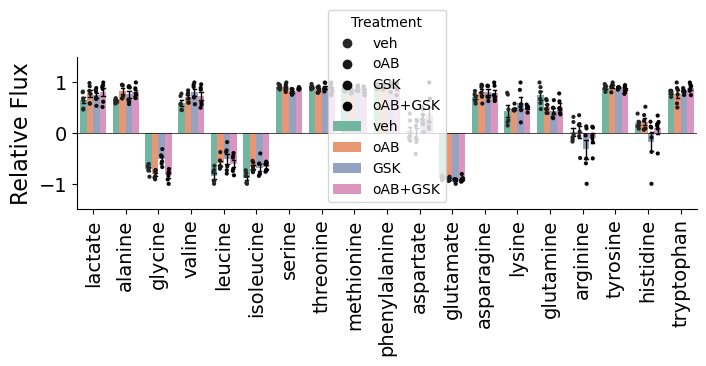

In [7]:


# Define the color palette
custom_palette = ['#fbb405','#911b1b','#696c46','#e2701b']

plt.figure(figsize=(8, 4))
sns.barplot(x='Metabolite', y='Ratio', hue='Treatment', data=Delta_MaxNorm_Wide, errorbar='se', errcolor='black', errwidth=1, capsize=0.1,palette=custom_palette)
sns.stripplot(x='Metabolite', y='Ratio', hue='Treatment', data=Delta_MaxNorm_Wide, dodge=True, jitter=True, color='black', size=3)
plt.xticks(rotation=90)

TextSize = 14

plt.gca().set_xlabel('')
plt.gca().set_ylabel('Relative Flux', fontsize=TextSize+2)

plt.tick_params(axis='x', labelsize=TextSize)
plt.tick_params(axis='y', labelsize=TextSize)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Legend = True
if not Legend:
    ax.get_legend().remove()

# Draw a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.5)

plt.ylim(-1.5, 1.5)

#plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.009, 1), fontsize=14, handletextpad=0)
plt.gcf().subplots_adjust(bottom=0.5)

plt.savefig(Directory_Path+'Flux_Barplot.pdf', format='pdf')

plt.show()

In [261]:
# Fit a linear model to the data
# Initialize the object
Design_Factors = 'Treatment'
Counts = (Delta_MaxNorm*1000+2000).round().astype(int).T

In [266]:
# Fit a linear model to the data
# Initialize the object
dds = DeseqDataSet(
    counts=Counts, # data must be converted to intigers
    metadata=MetaData.loc[MetaData.loc[:,'Time (Days)']==2,:],
    design_factors='Treatment',
    refit_cooks=False,
    #inference=inference,
    n_cpus=4, # n_cpus can be specified here or in the inference object
)

# Fit the model
dds.deseq2()

# Store the results
stat_res = DeseqStats(dds,contrast=['Treatment','vehicle','oAB'])
stat_res.summary()
Results = stat_res.results_df

Fitting size factors...
... done in 0.00 seconds.

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISA

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [263]:
Counts

,lactate,alanine,glycine,valine,leucine,isoleucine,serine,threonine,methionine,phenylalanine,aspartate,glutamate,asparagine,lysine,glutamine,arginine,tyrosine,histidine,tryptophan
,,,,,,,,,,,,,,,,,,,
sm57,2643,2585,1378,2733,1271,1213,2861,2970,2930,2912,1850,1108,2635,2762,2674,1869,2888,2137,2714
sm58,2485,2690,1286,2454,1056,1027,2972,2907,3000,2876,1914,1164,2722,2797,2593,1911,2877,2225,2836
sm59,2465,2645,1392,2582,1356,1267,2894,2890,2871,2950,2250,1071,2582,2219,2475,2321,2934,2131,2836
sm60,2682,2659,1140,2460,1000,1015,2901,2889,2819,2922,2385,1127,2771,2150,2908,2220,2916,2385,2769
sm61,2806,2603,1341,2780,1236,1153,2949,2925,2850,2976,1873,1094,2721,2470,2810,1969,2968,2088,2783
sm62,2820,2649,1263,2563,1057,1000,2891,2864,2843,2871,1956,1166,2832,2255,3000,1832,2814,2198,2821
sm63,2833,2738,1268,2843,1624,1453,2955,2889,2884,2931,2143,1055,2719,2461,2475,2162,2955,2092,2855
sm64,2926,2953,1151,2764,1339,1267,2892,2797,2796,2954,1908,1139,2942,2476,2647,2028,2805,2074,2586
sm65,2777,2684,1271,2685,1461,1420,2811,2922,2862,2857,1825,1081,2799,2453,2556,1509,2920,2356,2889


In [250]:
MetaData

,Sample,Treatment,Time (Days)
Sample,,,
fm1-1,fm1-1,veh,0
fm1-2,fm1-2,veh,0
fm1-3,fm1-3,veh,0
fm1-4,fm1-4,veh,0
fm1-5,fm1-5,veh,0
...,...,...,...
sm76,sm76,oAB+GSK,2
sm77,sm77,oAB+GSK,2
sm78,sm78,oAB+GSK,2
